In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT) 

/content/drive
Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/fb-project/data.csv ./

^C


In [ ]:
import numpy as np

from sklearn import preprocessing
import dateutil.parser as dateparser

from scipy import stats
import os

KeyboardInterrupt: ignored

In [ ]:
modelDir='/content/drive/MyDrive/dmw/model'
inFile='data.csv'
dataDir='./dataset'

a='2021-02-11T11:59:32.586367'
cutoff = dateparser.parse(a).timestamp()

testRatio=0.2
validationRatio=0.2

In [ ]:
if not os.path.isdir(dataDir):
  os.mkdir(dataDir)

In [ ]:
missing = []
total=0

with open(inFile,'r') as fp:
  fp.readline()
  lineNo=-1

  for l in fp:
    lineNo+=1
    arr=l[:-1].split(',')
    arr=arr[1:]
    if len(arr)==0:
      continue

    total+=1
    for k in range(len(arr)):
      if len(arr[k])==0:
        missing.append(k)

print(len(missing),np.unique(missing),total)

In [ ]:
def createToDropTable():
  toDrop=[]
  timeGap=[]

  with open(inFile,'r') as fp:
    fp.readline()
    lineNo=-1

    for l in fp:
      lineNo+=1
      arr=l[:-1].split(',')
      arr=arr[1:]
      if len(arr)==0:
        continue
      
      if len(arr[3])==0 or len(arr[4])==0:
        toDrop.append(lineNo)
      elif float(arr[4])-float(arr[3]) < 0:
        toDrop.append(lineNo)
      else:
        timeGap.append(float(arr[4])-float(arr[3]))
  
  finalCutoff=cutoff - np.median(timeGap)
  print(np.min(timeGap),np.max(timeGap),np.median(timeGap))

  with open(inFile,'r') as fp:
    fp.readline()
    lineNo=-1

    for l in fp:
      lineNo+=1
      arr=l[:-1].split(',')
      arr=arr[1:]
      if len(arr)==0:
        continue
      
      if len(arr[3])==0 or len(arr[4])==0:
        pass
      elif float(arr[3]) > finalCutoff:
        toDrop.append(lineNo)
  
  return toDrop

toDrop = createToDropTable()
print(total,len(toDrop),total-len(toDrop))

In [ ]:
### creating dictionaries 
dictToDrop={}
for i in toDrop:
  dictToDrop[i]=1

dictForMedian={}
uniqueMissing=np.unique(missing)
for k in uniqueMissing:
  dictForMedian[k]=[]

In [ ]:
def getMedian():
  with open(inFile,'r') as fp:
    fp.readline()
    lineNo=-1

    for l in fp:
      lineNo+=1
      arr=l[:-1].split(',')
      arr=arr[1:]
      if len(arr)==0 or lineNo in dictToDrop:
        continue
      
      for k in uniqueMissing:
        if (len(arr[k])):
          dictForMedian[k].append(float(arr[k]))

  for k in uniqueMissing:
    dictForMedian[k]=np.median(dictForMedian[k])

getMedian()
print(dictForMedian)


In [ ]:
size=total-len(toDrop)
arr=np.arange(size)
testSize=(int)(size*testRatio)
validationSize=(int)((size-testSize)*validationRatio)
trainSize=size -testSize - validationSize

In [ ]:
np.random.shuffle(arr)
testArr=arr[:testSize]
validationArr=arr[testSize:testSize+validationSize]
trainArr=arr[testSize+validationSize:]

testArr=np.sort(testArr)
trainArr=np.sort(trainArr)
validationArr=np.sort(validationArr)

print(len(testArr),len(trainArr),len(validationArr))

In [ ]:
def addFile(fileName,arrOfIndex):
  fileName=os.path.join(dataDir,fileName)

  effectiveRow=0
  arrIndex=0

  data=[]

  with open(inFile,'r') as fp:
    fp.readline()
    lineNo=-1

    for l in fp:
      if arrIndex >= len(arrOfIndex):
        break

      lineNo+=1
      arr=l[:-1].split(',')
      arr=arr[1:]
      if len(arr)==0 or lineNo in dictToDrop:
        continue
      
      #print(effectiveRow,arrOfIndex[arrIndex])
      if effectiveRow != arrOfIndex[arrIndex]:
        effectiveRow+=1
        continue

      effectiveRow+=1
      arrIndex+=1
      
      vec=[]
      for k in range(len(arr)):
        val=0
        if len(arr[k]) == 0:
          val = dictForMedian[k]
        else:
          val = float(arr[k]) 
        vec.append(val)
      
      # print(effectiveRow,len(vec),'================================')
      data.append(np.array(vec))

  data=np.array(data,dtype='float64')
  np.random.shuffle(data)
  np.save(fileName+'.npy',data)

In [ ]:
addFile('test',testArr)
addFile('val',validationArr)

In [ ]:
batch_size=3000
step=(int)(trainSize/batch_size)

for i in range(step):
  addFile('batch_'+str(i),trainArr[i*batch_size : (i+1)*batch_size])

if batch_size*step != trainSize:
  addFile('batch_'+str(step),trainArr[step*batch_size : ])



In [ ]:
#zip -r -9 dataset.zip ./dataset
#!cp -r ./dataset.zip /content/drive/MyDrive/fb-project/dataset.zip

**Neural Network**

In [ ]:
!cp -r  /content/drive/MyDrive/fb-project/dataset.zip ./

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/batch_3.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/batch_3.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/batch_3.npy     
  inflating: dataset/batch_1.npy     A

  inflating: dataset/val.npy         
  inflating: dataset/batch_0.npy     
  inflating: dataset/test.npy        
  inflating: dataset/batch_2.npy     


In [ ]:
import numpy as np
modelDir='/content/drive/MyDrive/dmw/model'

In [ ]:
b0=np.load('/content/dataset/batch_0.npy')
print(b0.shape)
b1=np.load('/content/dataset/batch_1.npy')
print(b1.shape)
b2=np.load('/content/dataset/batch_2.npy')
print(b2.shape)
b3=np.load('/content/dataset/batch_3.npy')
print(b3.shape)
val=np.load('/content/dataset/val.npy')
print(val.shape)


(3000, 25199)
(3000, 25199)
(3000, 25199)
(2912, 25199)
(2977, 25199)


In [ ]:
data = np.concatenate((b0,b1,b2,b3,val), axis=0)
del b0
del b1
del b2
del b3
del val

data=data[:,:-2]
print(data.shape)

(14889, 25197)


In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error
from sklearn.externals import joblib

import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import plot_model
from IPython.display import Image


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def saveModel(name,model,scaler):
  model_json = model.to_json()
  with open(os.path.join(modelDir,name+".json"), "w") as json_file:
    json_file.write(model_json)

  model.save_weights(os.path.join(modelDir,name+".h5"))
  
  joblib.dump(scaler, os.path.join(modelDir,name+"_scaler"))

  print("Saved model to disk")

In [ ]:
def loadModel(name):
  json_file = open(os.path.join(modelDir,name+".json"), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = keras.models.model_from_json(loaded_model_json)
  
  model.load_weights(os.path.join(modelDir,name+".h5"))

  scaler=joblib.load(os.path.join(modelDir,name+"_scaler"))
  
  print("Loaded model from disk")

  return model,scaler

In [ ]:
def split_X_Y(data):
  #return data[:,:-3],data[:,-3:]
  return data[:,:-1],data[:,-1].reshape(-1,1)

In [ ]:
validationRatio=0.2

In [ ]:
def split_train_val(data, val_ratio=validationRatio):
  shuffled_indices = np.random.permutation(len(data))
  val_set_size = int(len(data) * val_ratio)
  val_indices = shuffled_indices[:val_set_size]
  train_indices = shuffled_indices[val_set_size:]
  return data[train_indices], data[val_indices]

train,val=split_train_val(data)
del data
print(train.shape,val.shape)

(11912, 25197) (2977, 25197)


In [ ]:
scaler = Scaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)

In [ ]:
train_x,train_y=split_X_Y(train)
del train
print(train_x.shape,train_y.shape)

val_x,val_y=split_X_Y(val)
del val
print(val_x.shape,val_y.shape)

(11912, 25196) (11912, 1)
(2977, 25196) (2977, 1)


In [ ]:
def getModel3(normalFeatures, textFeatures, visualFeatures, outputShape):
    input = keras.Input(shape=(normalFeatures + textFeatures +
                               visualFeatures, ))

    normalInput = input[:, :normalFeatures]

    textInput = input[:, normalFeatures:textFeatures + normalFeatures]

    visualFeatures = input[:, textFeatures + normalFeatures:]

    visualFeatures = keras.layers.Dropout(0.5, name='Visual_features_dropout')(visualFeatures)

    textInputReshaped = keras.layers.Dense(
        300,
        activation='elu',
        name="reshaping_text",
        kernel_regularizer=keras.regularizers.l2(0.01))(
            textInput)  ############

    visualInputReshaped = keras.layers.Dense(
        300,
        activation='elu',
        name="reshaping_visual",
        kernel_regularizer=keras.regularizers.l2(0.01))(
            visualFeatures)  ###########

    ### At-fusion#############################
    tanh_layer = keras.layers.Dense(
        300,
        use_bias=False,
        activation='tanh',
        name="at_fusion_tanh",
        kernel_regularizer=keras.regularizers.l2(0.01))  ############

    text1 = tanh_layer(textInputReshaped)

    visual1 = tanh_layer(visualInputReshaped)

    linear_layer = keras.layers.Dense(
        1,
        use_bias=False,
        activation='linear',
        name="at_fusion_linear",
        kernel_regularizer=keras.regularizers.l2(0.01))  ############

    text2 = linear_layer(text1)

    visual2 = linear_layer(visual1)

    merge = keras.layers.Concatenate(axis=1)([text2, visual2])

    alpha_fuse = keras.layers.Dense(2,
                                    activation='softmax',
                                    name="at_fusion_softmax")(merge)

    alpha1_expanded = tf.expand_dims(alpha_fuse[:, 0], 1)

    text3 = keras.layers.multiply([textInputReshaped, alpha1_expanded])

    alpha2_expanded = tf.expand_dims(alpha_fuse[:, 0], 1)

    visual3 = keras.layers.multiply([visualInputReshaped, alpha2_expanded])

    F = keras.layers.Add()([text3, visual3])
    ###########################################

    F2 = tf.keras.layers.Concatenate(axis=1)([normalInput, F])

    F2 = keras.layers.BatchNormalization()(F2)

    F2 = keras.layers.Dropout(0.5)(F2)
    hidden = keras.layers.Dense(
        308,
        activation='elu',
        name="hidden1",
        kernel_regularizer=keras.regularizers.l2(0.01))(F2)  ##########

    hidden = keras.layers.Dropout(0.5)(hidden)

    hidden = keras.layers.Dense(
        308,
        activation='elu',
        name="hidden2",
        kernel_regularizer=keras.regularizers.l2(0.01))(hidden)  #########

    output = keras.layers.Dense(outputShape,
                                activation='linear',
                                name="linear")(hidden)

    model = keras.Model(input, output)

    return model


In [ ]:
def getModel2(inputShape,outputShape):
  model = keras.Sequential([
      keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01),
                  activation='relu', input_shape=(inputShape,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01),
                  activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01),
                  activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01),
                  activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01),
                  activation='relu'),
                  
      keras.layers.Dense(outputShape, activation='linear')
  ])

  return model

In [ ]:
model = getModel3(8,100,25088,1)
#model = getModel2(train_x.shape[1],train_y.shape[1])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25196)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 25088)        0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
Visual_features_dropout (Dropou (None, 25088)        0           tf.__operators__.getitem_2[0][0] 
______________________________________________________________________________________________

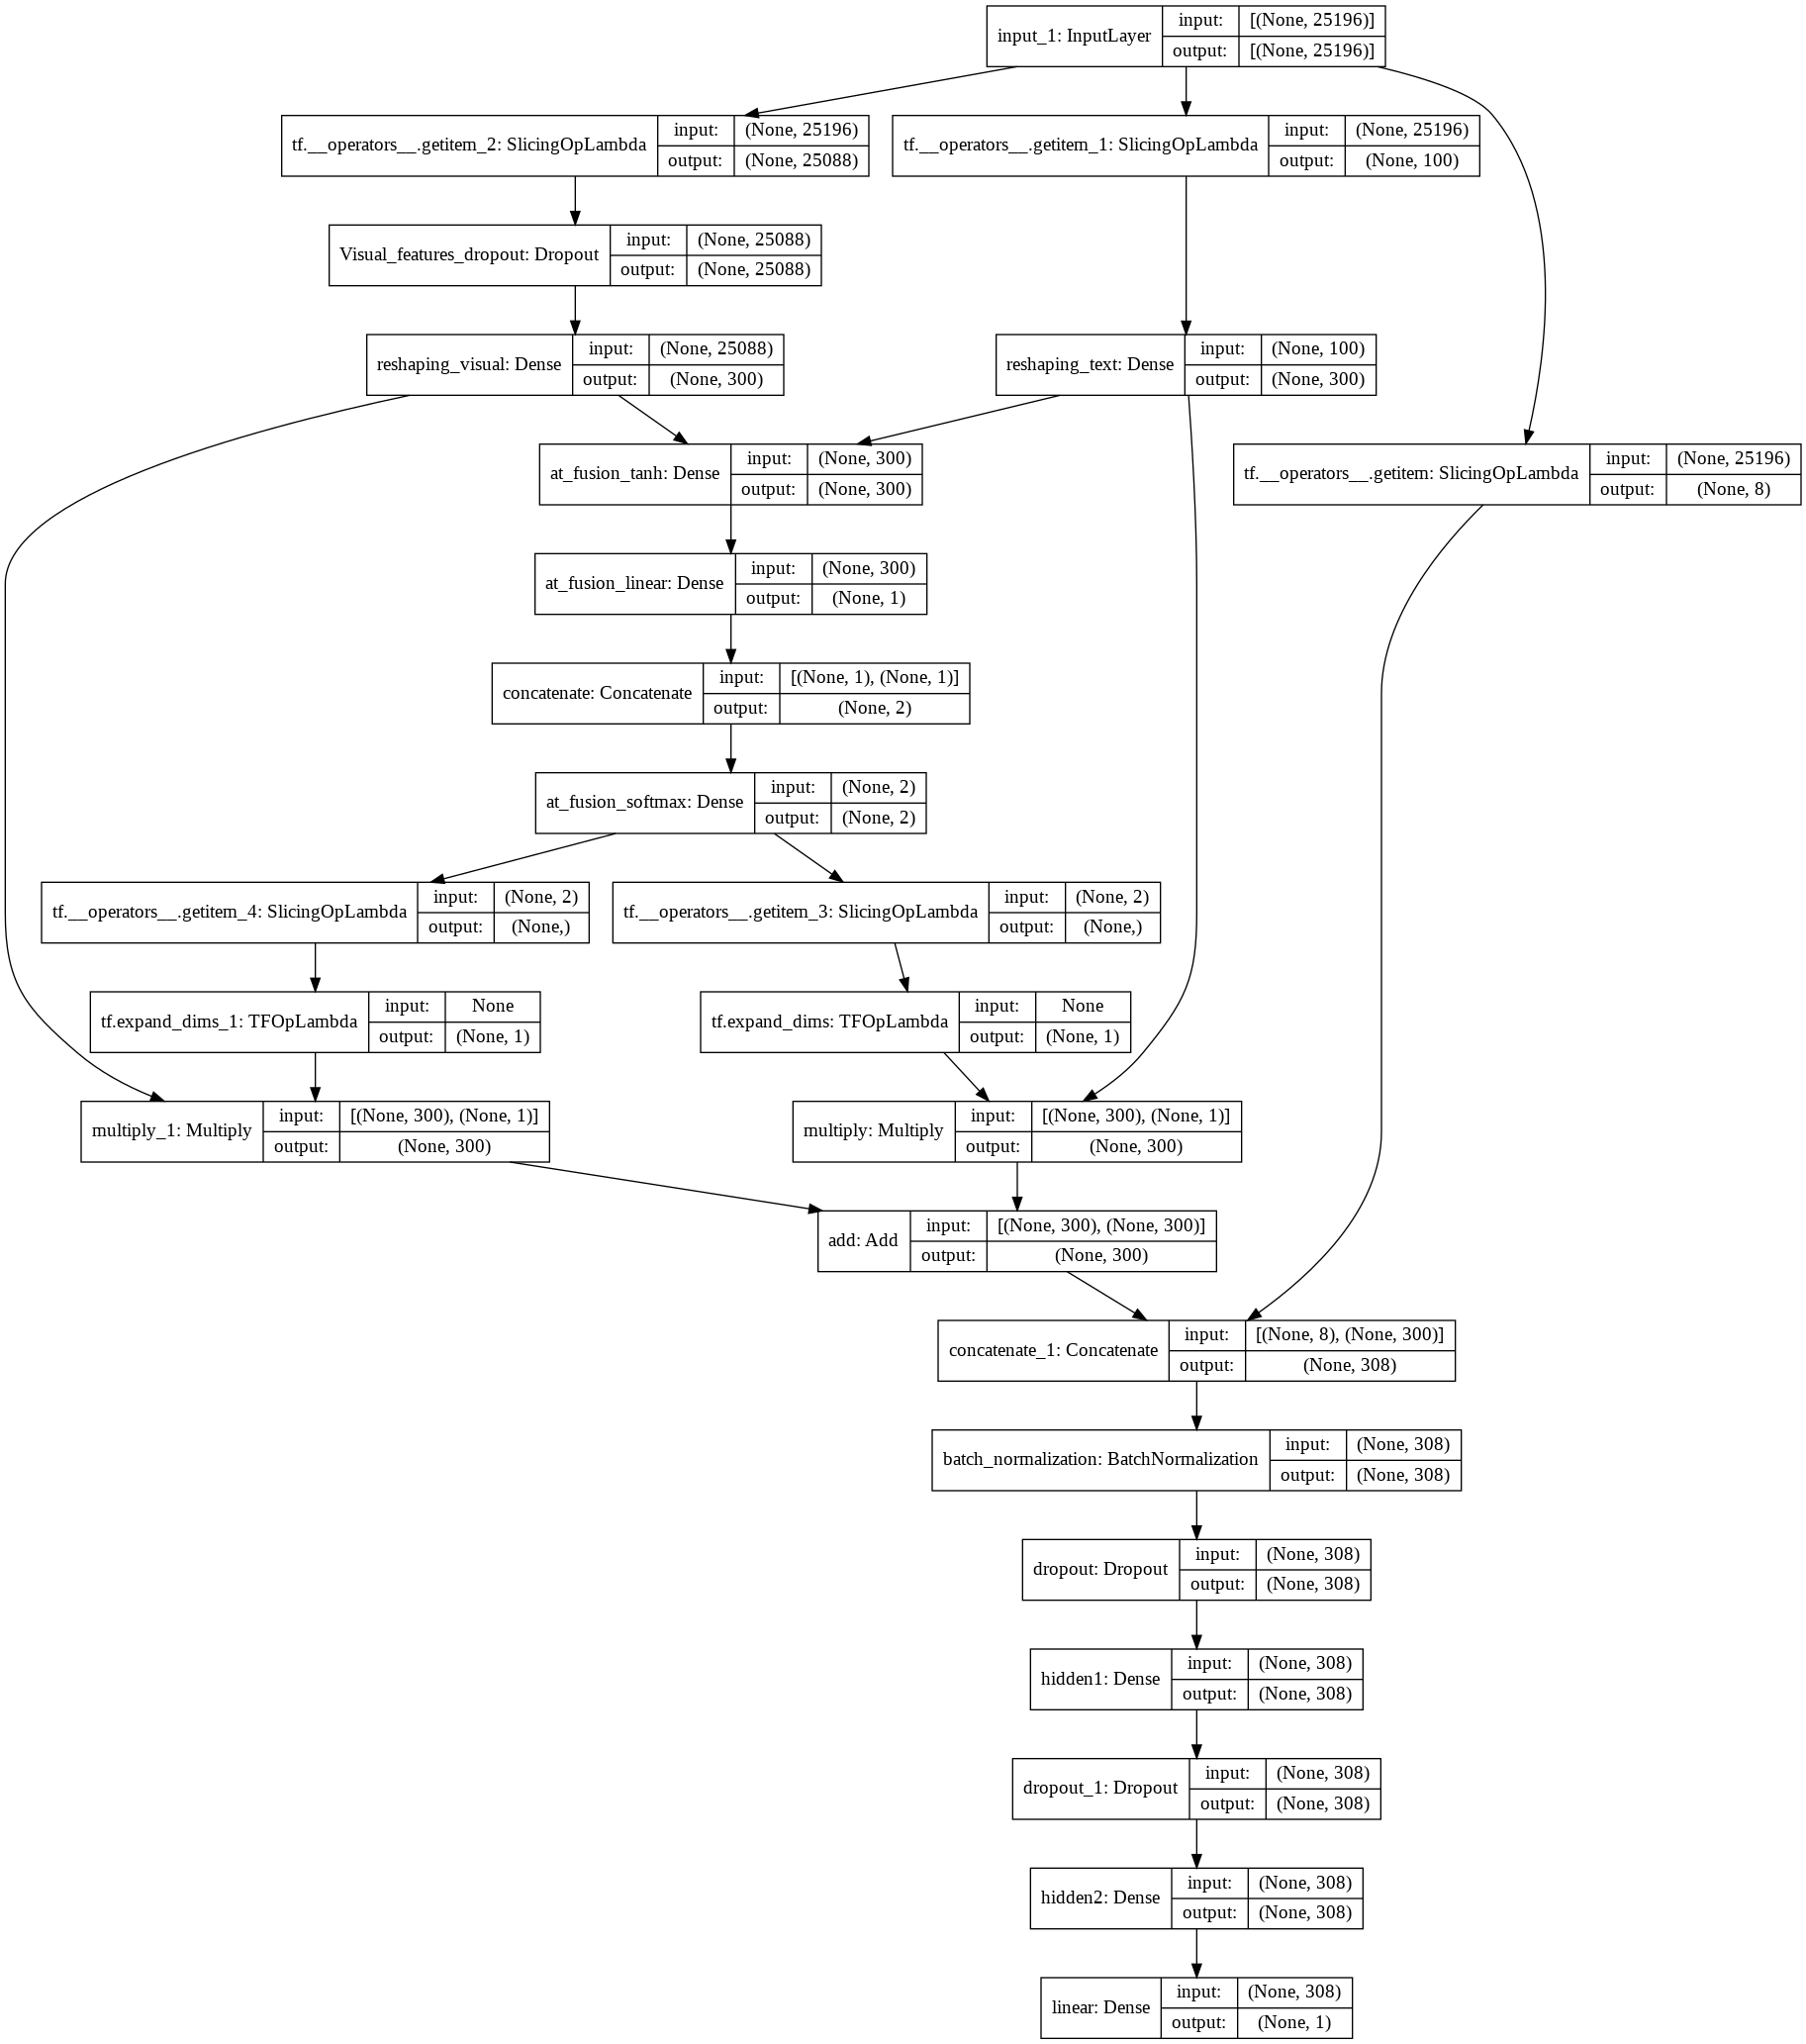

In [ ]:
model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error'])
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [ ]:
model_name="model"
model.fit(train_x, train_y,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=(val_x,val_y)
                )

In [ ]:
saveModel(model_name,model,scaler)

Saved model to disk


In [ ]:
def testModel(name=None):

  test=val=np.load('/content/dataset/test.npy')
  test=test[:,:-2]

  test2=scaler.transform(test)

  test_x,test_y=split_X_Y(test2)

  yhat = model.predict(test_x)

  mae = mean_absolute_error(test_y, yhat)
  print('MAE: %.5f' % mae)
  mse = mean_squared_error(test_y, yhat)
  print('MSE: %.5f' % mse)

  print(model.evaluate(test_x,test_y))

  if name==None:
    return

  test2[:,-3:]=yhat
  test2=scaler.inverse_transform(test2)
  
  fileAns=name+'_comparison.csv'

  with open(fileAns,'w') as fp:
    #fp.write('reaction,comment_sentiment,comment_count,predicted_reaction,predicted_comment_sentiment,predicted_comment_count\n')
    fp.write('reactions,predicted_reactions\n')
    for i in range(len(test)):
      st=''
      for j in range(-1,0):
        st+=str(test[i][j])+','

      for j in range(-1,0):
        st+=str(test2[i][j])+','
      
      fp.write(st[:-1]+'\n')

In [ ]:
testModel('model')

MAE: 0.03010
MSE: 0.00326
117/117 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[0.0033003687858581543, 0.0032615282107144594]


In [ ]:
y